1. Import necessary packages

In [13]:
import numpy as np
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

import seaborn as sns
import torch.nn.functional as F

2. Set random seed for reproducibility

In [14]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # disables optimizations for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

3. Load the train data

In [15]:
# Load the combined_labels.npy file
mytool = "pneumatic_screwdriver"
output_dir = "./processed_data/"

# Load the saved NumPy arrays
combined_data = np.load(os.path.join(output_dir, f"combined_data_train_{mytool}.npy"))
combined_labels = np.load(os.path.join(output_dir, f"combined_label_train_{mytool}.npy"))

4. Perform training with k fold validation


--- Fold 1 ---
Epoch 1: Train Acc = 0.2835, Val Acc = 0.3356
Epoch 2: Train Acc = 0.3265, Val Acc = 0.3356
Epoch 3: Train Acc = 0.3402, Val Acc = 0.3151
Epoch 4: Train Acc = 0.3316, Val Acc = 0.3356
Epoch 5: Train Acc = 0.3436, Val Acc = 0.3562
Epoch 6: Train Acc = 0.4003, Val Acc = 0.4932
Epoch 7: Train Acc = 0.4931, Val Acc = 0.5068
Epoch 8: Train Acc = 0.5103, Val Acc = 0.5822
Epoch 9: Train Acc = 0.5704, Val Acc = 0.4726
Epoch 10: Train Acc = 0.5584, Val Acc = 0.5479
Epoch 11: Train Acc = 0.6134, Val Acc = 0.5548
Epoch 12: Train Acc = 0.6065, Val Acc = 0.5753
Epoch 13: Train Acc = 0.6340, Val Acc = 0.6370
Epoch 14: Train Acc = 0.6546, Val Acc = 0.6507
Epoch 15: Train Acc = 0.6856, Val Acc = 0.6370
Epoch 16: Train Acc = 0.7045, Val Acc = 0.6644
Epoch 17: Train Acc = 0.7199, Val Acc = 0.6781
Epoch 18: Train Acc = 0.6959, Val Acc = 0.7123
Epoch 19: Train Acc = 0.7199, Val Acc = 0.6644
Epoch 20: Train Acc = 0.7423, Val Acc = 0.6918
Epoch 21: Train Acc = 0.6856, Val Acc = 0.6781
Epoch 

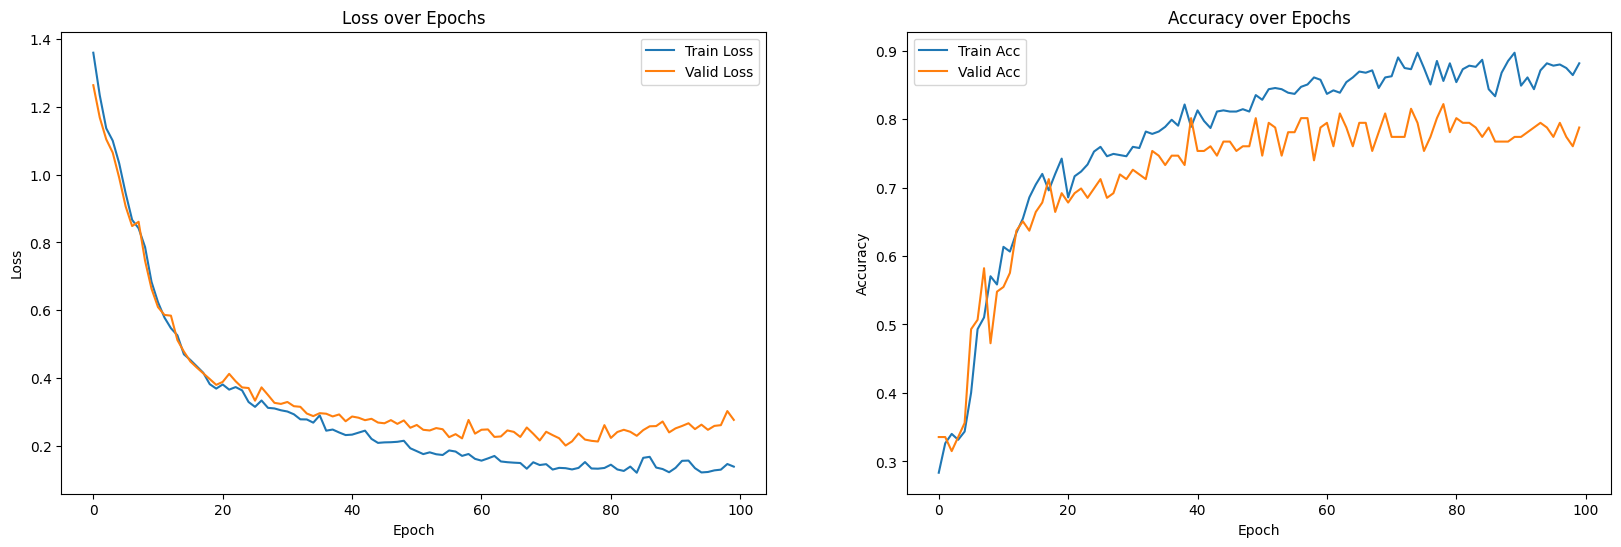

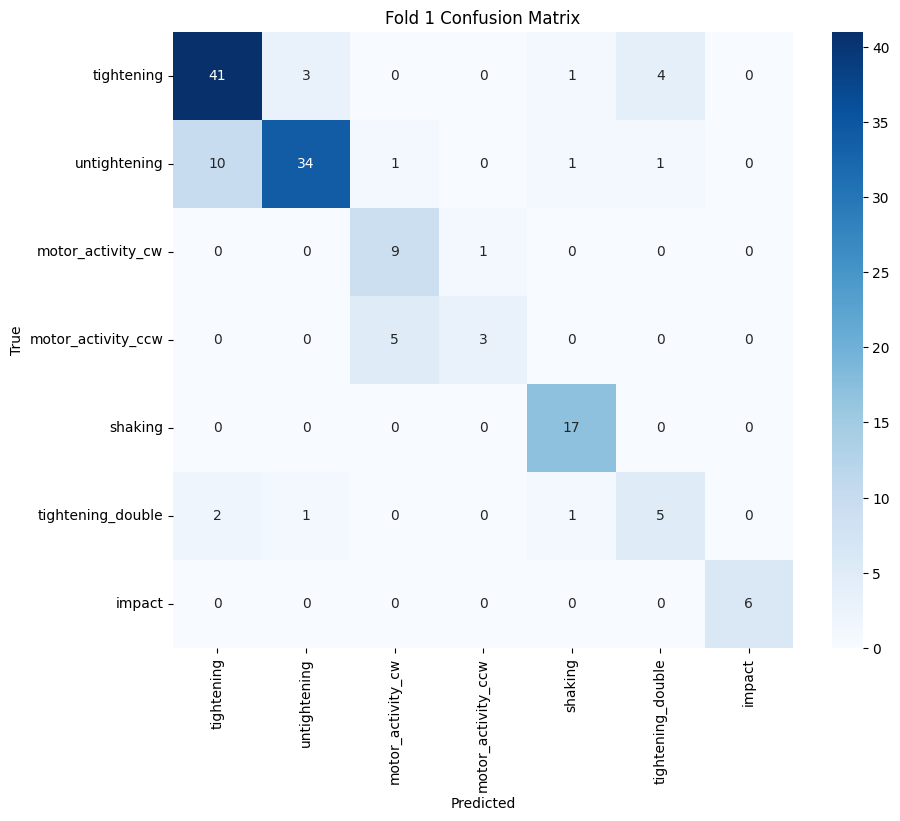


--- Fold 2 ---
Epoch 1: Train Acc = 0.3436, Val Acc = 0.3356
Epoch 2: Train Acc = 0.3299, Val Acc = 0.3288
Epoch 3: Train Acc = 0.3574, Val Acc = 0.3904
Epoch 4: Train Acc = 0.4107, Val Acc = 0.4521
Epoch 5: Train Acc = 0.4296, Val Acc = 0.5137
Epoch 6: Train Acc = 0.4691, Val Acc = 0.5685
Epoch 7: Train Acc = 0.5344, Val Acc = 0.5890
Epoch 8: Train Acc = 0.5481, Val Acc = 0.6370
Epoch 9: Train Acc = 0.5756, Val Acc = 0.5822
Epoch 10: Train Acc = 0.5945, Val Acc = 0.6301
Epoch 11: Train Acc = 0.5997, Val Acc = 0.6575
Epoch 12: Train Acc = 0.6392, Val Acc = 0.6164
Epoch 13: Train Acc = 0.6495, Val Acc = 0.6644
Epoch 14: Train Acc = 0.6289, Val Acc = 0.6027
Epoch 15: Train Acc = 0.6615, Val Acc = 0.6712
Epoch 16: Train Acc = 0.6890, Val Acc = 0.6849
Epoch 17: Train Acc = 0.7079, Val Acc = 0.7329
Epoch 18: Train Acc = 0.7113, Val Acc = 0.7192
Epoch 19: Train Acc = 0.7509, Val Acc = 0.7466
Epoch 20: Train Acc = 0.7199, Val Acc = 0.7534
Epoch 21: Train Acc = 0.7405, Val Acc = 0.7397
Epoch 

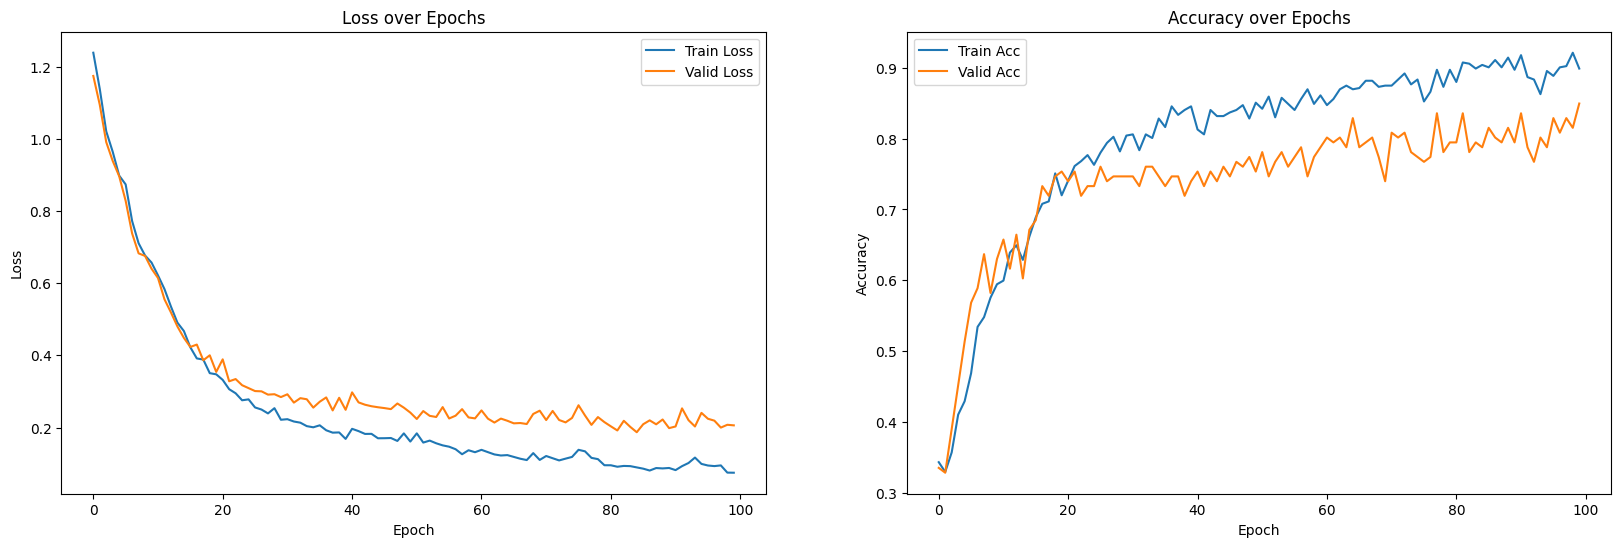

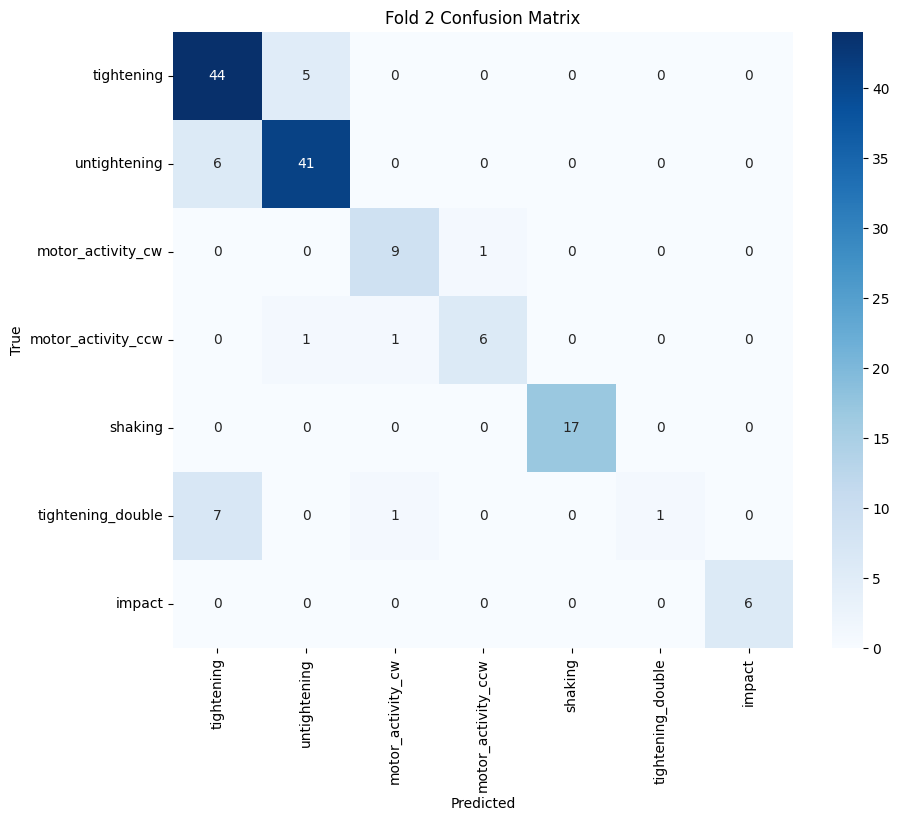


--- Fold 3 ---
Epoch 1: Train Acc = 0.2680, Val Acc = 0.3219
Epoch 2: Train Acc = 0.3316, Val Acc = 0.3288
Epoch 3: Train Acc = 0.3368, Val Acc = 0.3562
Epoch 4: Train Acc = 0.3832, Val Acc = 0.3699
Epoch 5: Train Acc = 0.4003, Val Acc = 0.4384
Epoch 6: Train Acc = 0.4742, Val Acc = 0.4932
Epoch 7: Train Acc = 0.5223, Val Acc = 0.5068
Epoch 8: Train Acc = 0.5567, Val Acc = 0.5616
Epoch 9: Train Acc = 0.5739, Val Acc = 0.6233
Epoch 10: Train Acc = 0.6082, Val Acc = 0.6027
Epoch 11: Train Acc = 0.6237, Val Acc = 0.5890
Epoch 12: Train Acc = 0.6598, Val Acc = 0.6438
Epoch 13: Train Acc = 0.6821, Val Acc = 0.6507
Epoch 14: Train Acc = 0.6701, Val Acc = 0.6438
Epoch 15: Train Acc = 0.6959, Val Acc = 0.6644
Epoch 16: Train Acc = 0.7148, Val Acc = 0.6712
Epoch 17: Train Acc = 0.7216, Val Acc = 0.7192
Epoch 18: Train Acc = 0.7251, Val Acc = 0.7329
Epoch 19: Train Acc = 0.7577, Val Acc = 0.7123
Epoch 20: Train Acc = 0.7371, Val Acc = 0.6918
Epoch 21: Train Acc = 0.7509, Val Acc = 0.7055
Epoch 

c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

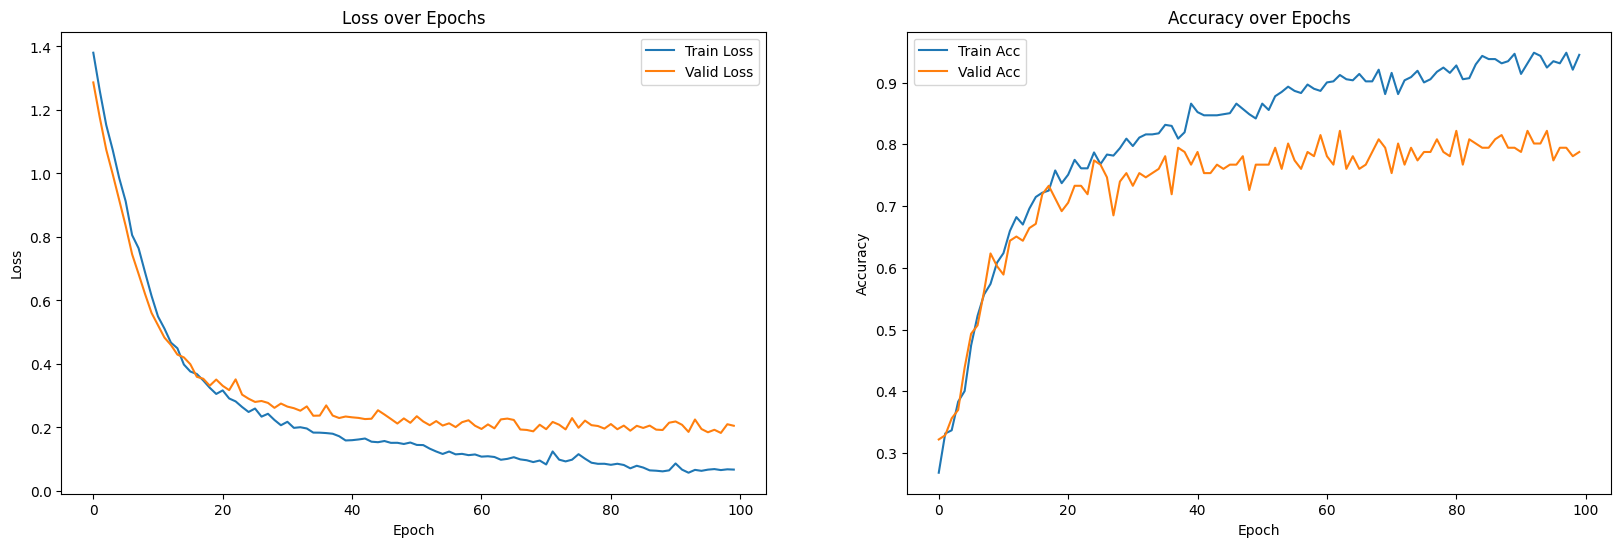

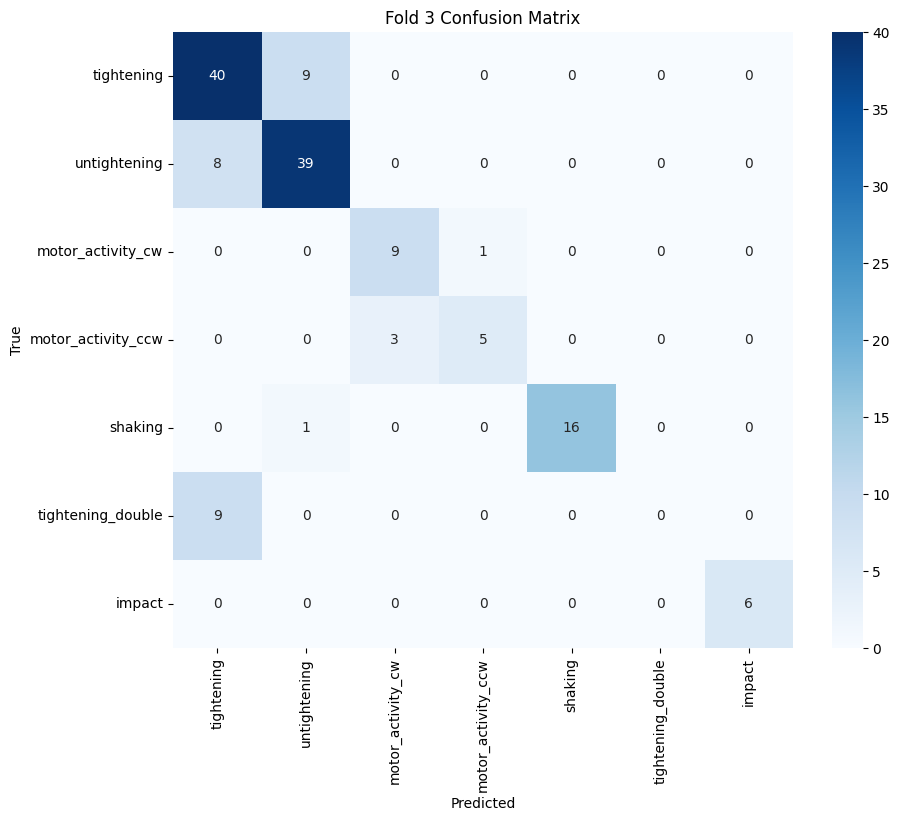


--- Fold 4 ---
Epoch 1: Train Acc = 0.2504, Val Acc = 0.3310
Epoch 2: Train Acc = 0.3328, Val Acc = 0.3310
Epoch 3: Train Acc = 0.3431, Val Acc = 0.3379
Epoch 4: Train Acc = 0.3654, Val Acc = 0.4483
Epoch 5: Train Acc = 0.5077, Val Acc = 0.5241
Epoch 6: Train Acc = 0.5472, Val Acc = 0.5931
Epoch 7: Train Acc = 0.5832, Val Acc = 0.6069
Epoch 8: Train Acc = 0.6346, Val Acc = 0.6483
Epoch 9: Train Acc = 0.6312, Val Acc = 0.6276
Epoch 10: Train Acc = 0.6552, Val Acc = 0.6621
Epoch 11: Train Acc = 0.6707, Val Acc = 0.6621
Epoch 12: Train Acc = 0.6947, Val Acc = 0.7034
Epoch 13: Train Acc = 0.6947, Val Acc = 0.7310
Epoch 14: Train Acc = 0.7376, Val Acc = 0.7517
Epoch 15: Train Acc = 0.7667, Val Acc = 0.7103
Epoch 16: Train Acc = 0.7307, Val Acc = 0.7586
Epoch 17: Train Acc = 0.7513, Val Acc = 0.7310
Epoch 18: Train Acc = 0.7530, Val Acc = 0.7448
Epoch 19: Train Acc = 0.7770, Val Acc = 0.7379
Epoch 20: Train Acc = 0.7650, Val Acc = 0.7034
Epoch 21: Train Acc = 0.7530, Val Acc = 0.7517
Epoch 

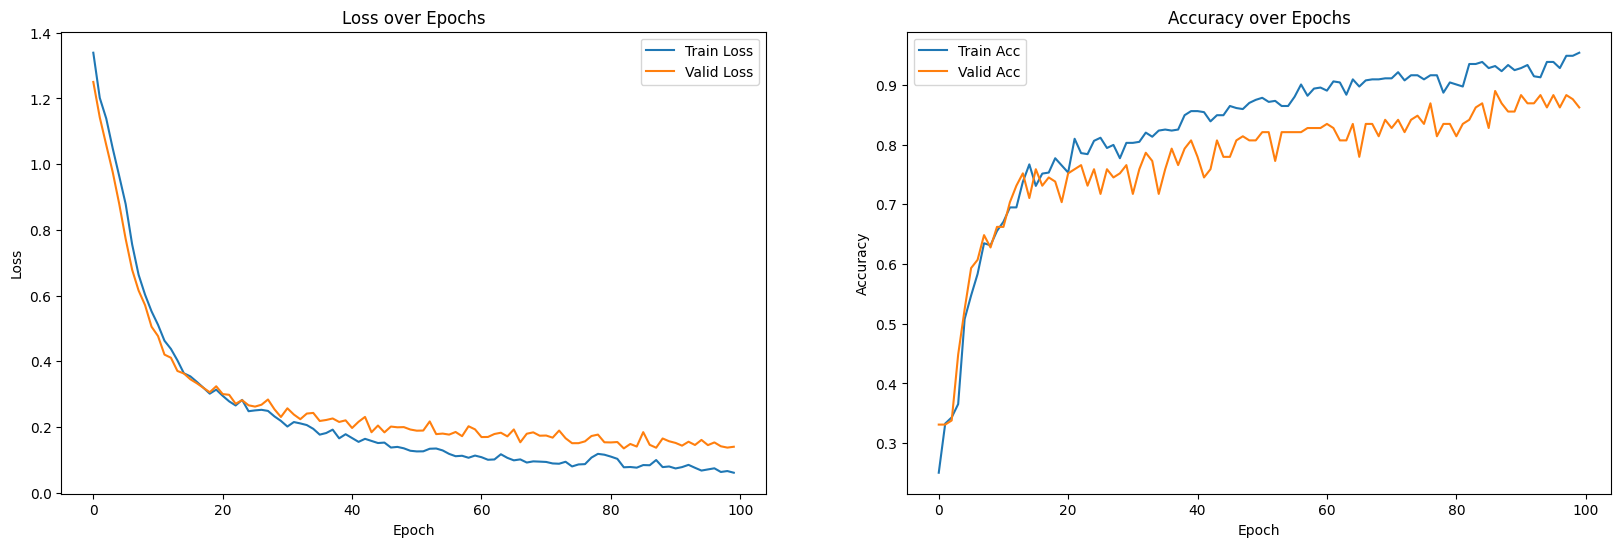

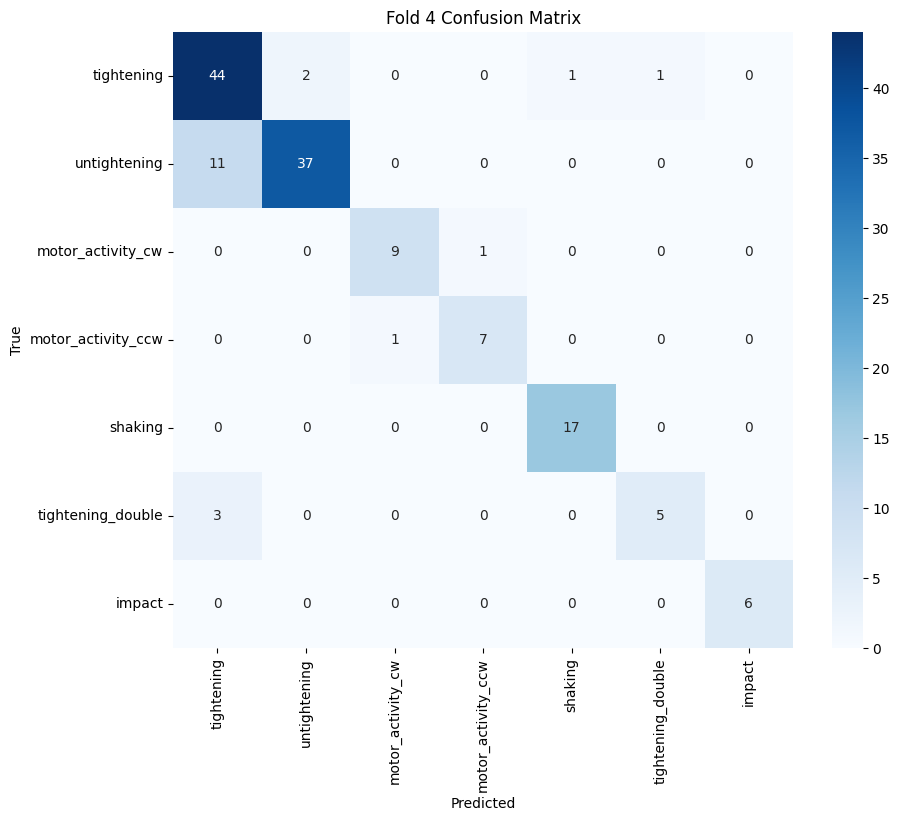


--- Fold 5 ---
Epoch 1: Train Acc = 0.2762, Val Acc = 0.3310
Epoch 2: Train Acc = 0.3431, Val Acc = 0.3310
Epoch 3: Train Acc = 0.4305, Val Acc = 0.5241
Epoch 4: Train Acc = 0.4751, Val Acc = 0.5793
Epoch 5: Train Acc = 0.5592, Val Acc = 0.6069
Epoch 6: Train Acc = 0.5506, Val Acc = 0.6069
Epoch 7: Train Acc = 0.5712, Val Acc = 0.6069
Epoch 8: Train Acc = 0.6192, Val Acc = 0.5586
Epoch 9: Train Acc = 0.6021, Val Acc = 0.6759
Epoch 10: Train Acc = 0.6467, Val Acc = 0.6207
Epoch 11: Train Acc = 0.6518, Val Acc = 0.7103
Epoch 12: Train Acc = 0.6758, Val Acc = 0.5793
Epoch 13: Train Acc = 0.6827, Val Acc = 0.6552
Epoch 14: Train Acc = 0.6861, Val Acc = 0.6621
Epoch 15: Train Acc = 0.7136, Val Acc = 0.7379
Epoch 16: Train Acc = 0.7238, Val Acc = 0.7241
Epoch 17: Train Acc = 0.7015, Val Acc = 0.6690
Epoch 18: Train Acc = 0.7341, Val Acc = 0.7448
Epoch 19: Train Acc = 0.7170, Val Acc = 0.7448
Epoch 20: Train Acc = 0.7547, Val Acc = 0.7586
Epoch 21: Train Acc = 0.7547, Val Acc = 0.7793
Epoch 

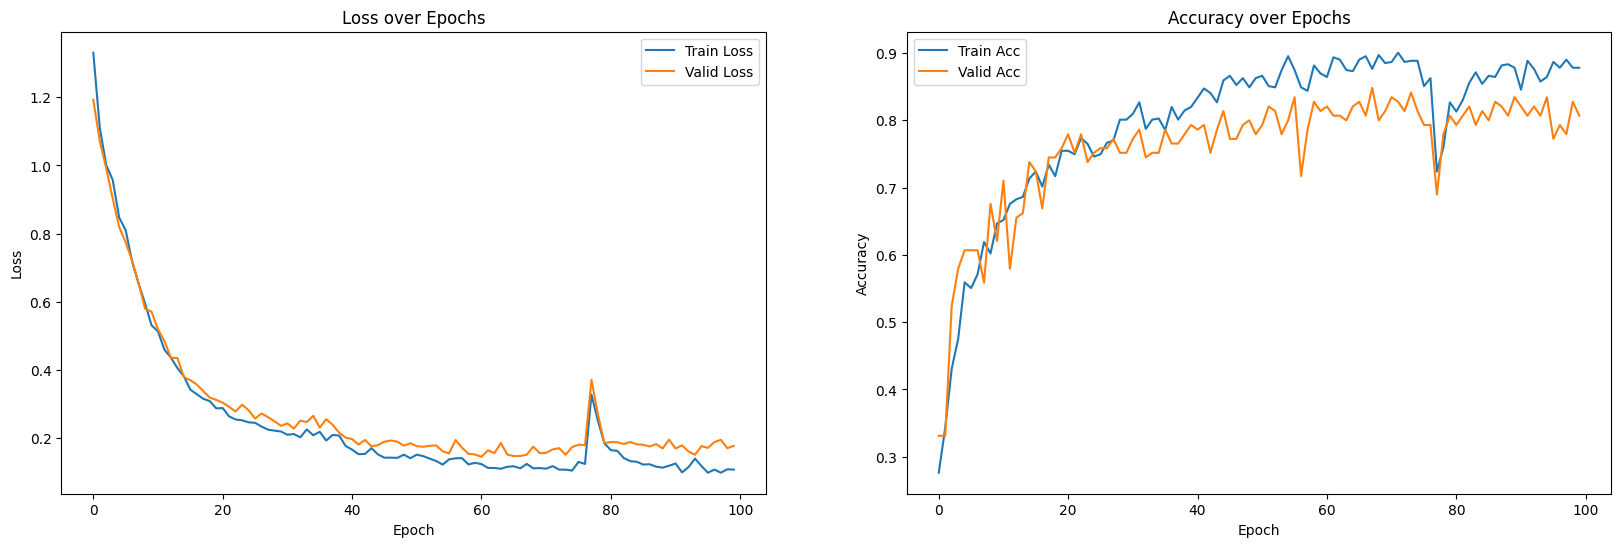

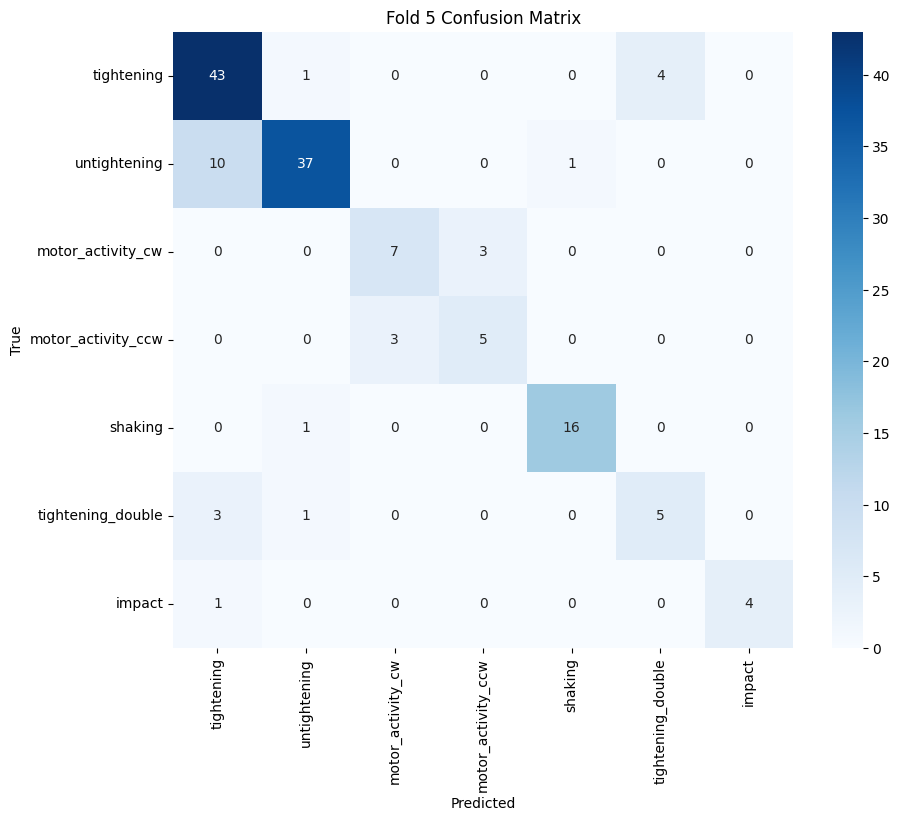


Average Accuracy over 5 folds: 0.8187
Average Weighted F1 Score over 5 folds: 0.8099


In [16]:
if mytool == "eletric_screwdriver":
    label_info = {
        2: 'tightening',
        3: 'untightening',
        4: 'motor_activity_cw',
        5: 'motor_activity_ccw',
        6: 'manual_motor_rotation',
        7: 'shaking',
        14: 'tightening_double'
    }
elif mytool == "pneumatic_screwdriver":
    label_info = {
        2: 'tightening',
        3: 'untightening',
        4: 'motor_activity_cw',
        5: 'motor_activity_ccw',
        7: 'shaking',
        14: 'tightening_double',
        38: 'impact'
    }

valid_labels = list(label_info.keys())

X = combined_data
y = combined_labels

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y_encoded)

# ---------------- Model and Loss ---------------- #
class EnhancedToolLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.1):
        super(EnhancedToolLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.dropout(last_out)
        return self.fc(out)

class SimpleFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(SimpleFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha, dtype=torch.float32) if alpha is not None else None

    def forward(self, inputs, targets):
        device = inputs.device
        log_probs = F.log_softmax(inputs, dim=1)
        probs = log_probs.exp()
        log_probs_true = log_probs.gather(1, targets.view(-1, 1)).squeeze(1)
        probs_true = probs.gather(1, targets.view(-1, 1)).squeeze(1).clamp(min=1e-9)
        if self.alpha is not None:
            alpha_t = self.alpha.to(device)[targets]
            loss = -alpha_t * (1 - probs_true)**self.gamma * log_probs_true
        else:
            loss = - (1 - probs_true)**self.gamma * log_probs_true
        return loss.mean()

# ---------------- K-Fold Training Loop ---------------- #
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X.shape[2]
output_dim = len(label_info)
hidden_dim = 64
batch_size = 32
num_epochs = 100

fold_accuracies, fold_f1s = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_tensor, y_tensor)):
    print(f"\n--- Fold {fold+1} ---")

    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    model = EnhancedToolLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
    criterion = SimpleFocalLoss(gamma=2.0)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        valid_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        valid_losses.append(valid_loss / len(val_loader))
        valid_accuracies.append(correct / total)
        print(f"Epoch {epoch+1}: Train Acc = {train_accuracies[-1]:.4f}, Val Acc = {valid_accuracies[-1]:.4f}")

    # Final Evaluation on Validation Set
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    fold_accuracies.append(acc)
    fold_f1s.append(f1)

    # Training Curves
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(valid_accuracies, label='Valid Acc')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    print(f"\nFold {fold+1} Accuracy: {acc:.4f}")
    print(f"Fold {fold+1} Weighted F1 Score: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=[label_info[i] for i in valid_labels]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_info.values(), yticklabels=label_info.values())
    plt.title(f'Fold {fold+1} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# ---------------- Overall Summary ---------------- #
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(fold_accuracies):.4f}")
print(f"Average Weighted F1 Score over {n_splits} folds: {np.mean(fold_f1s):.4f}")


5. Save the trained model

In [17]:
# Define directory for saving
model_dir = "./trained_model/"
os.makedirs(model_dir, exist_ok=True)

# File path to save the weights
model_file = os.path.join(model_dir, f"enhanced_lstm_model_{mytool}.pth")

# Save the state dictionary
torch.save(model.state_dict(), model_file)

print(f"Model successfully saved to {model_file}.")


Model successfully saved to ./trained_model/enhanced_lstm_model_pneumatic_screwdriver.pth.


6. Load the model for testing

In [18]:
# Reload the model with the SAME architecture first
num_of_classes = len(label_info)
model = EnhancedToolLSTM(input_dim=X.shape[2],
                           hidden_dim=64,
                           output_dim=num_of_classes)
model.to(device)

# File path for the trained weights
model_file = os.path.join(model_dir, f"enhanced_lstm_model_{mytool}.pth")

# Loading weights into the new instance
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print("Model successfully loaded.")


Model successfully loaded.


7. Evaluate the model on test data

In [19]:
# Load the combined_labels.npy file
output_dir = "./processed_data/"

# Load the saved NumPy arrays
combined_data = np.load(os.path.join(output_dir, f"combined_data_test_{mytool}.npy"))
combined_labels = np.load(os.path.join(output_dir, f"combined_label_test_{mytool}.npy"))

# Label mapping
if mytool == "eletric_screwdriver":
    label_info = {
        2: 'tightening',
        3: 'untightening',
        4: 'motor_activity_cw',
        5: 'motor_activity_ccw',
        6: 'manual_motor_rotation',
        7: 'shaking',
        14: 'tightening_double'
    }
elif mytool == "pneumatic_screwdriver":
    label_info = {
        2: 'tightening',
        3: 'untightening',
        4: 'motor_activity_cw',
        5: 'motor_activity_ccw',
        7: 'shaking',
        14: 'tightening_double',
        38: 'impact'
    }

valid_labels = list(label_info.keys())
valid_indices = np.isin(combined_labels, valid_labels)
# X = combined_data[valid_indices]
X = combined_data[valid_indices]
y = combined_labels[valid_indices]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) # can be removed as our code uses binary labels directly

# Convert to tensors
X_tensor_test = torch.FloatTensor(X)
y_tensor_test = torch.LongTensor(y_encoded)


Final Accuracy: 0.7967
Final Weighted F1 Score: 0.7969


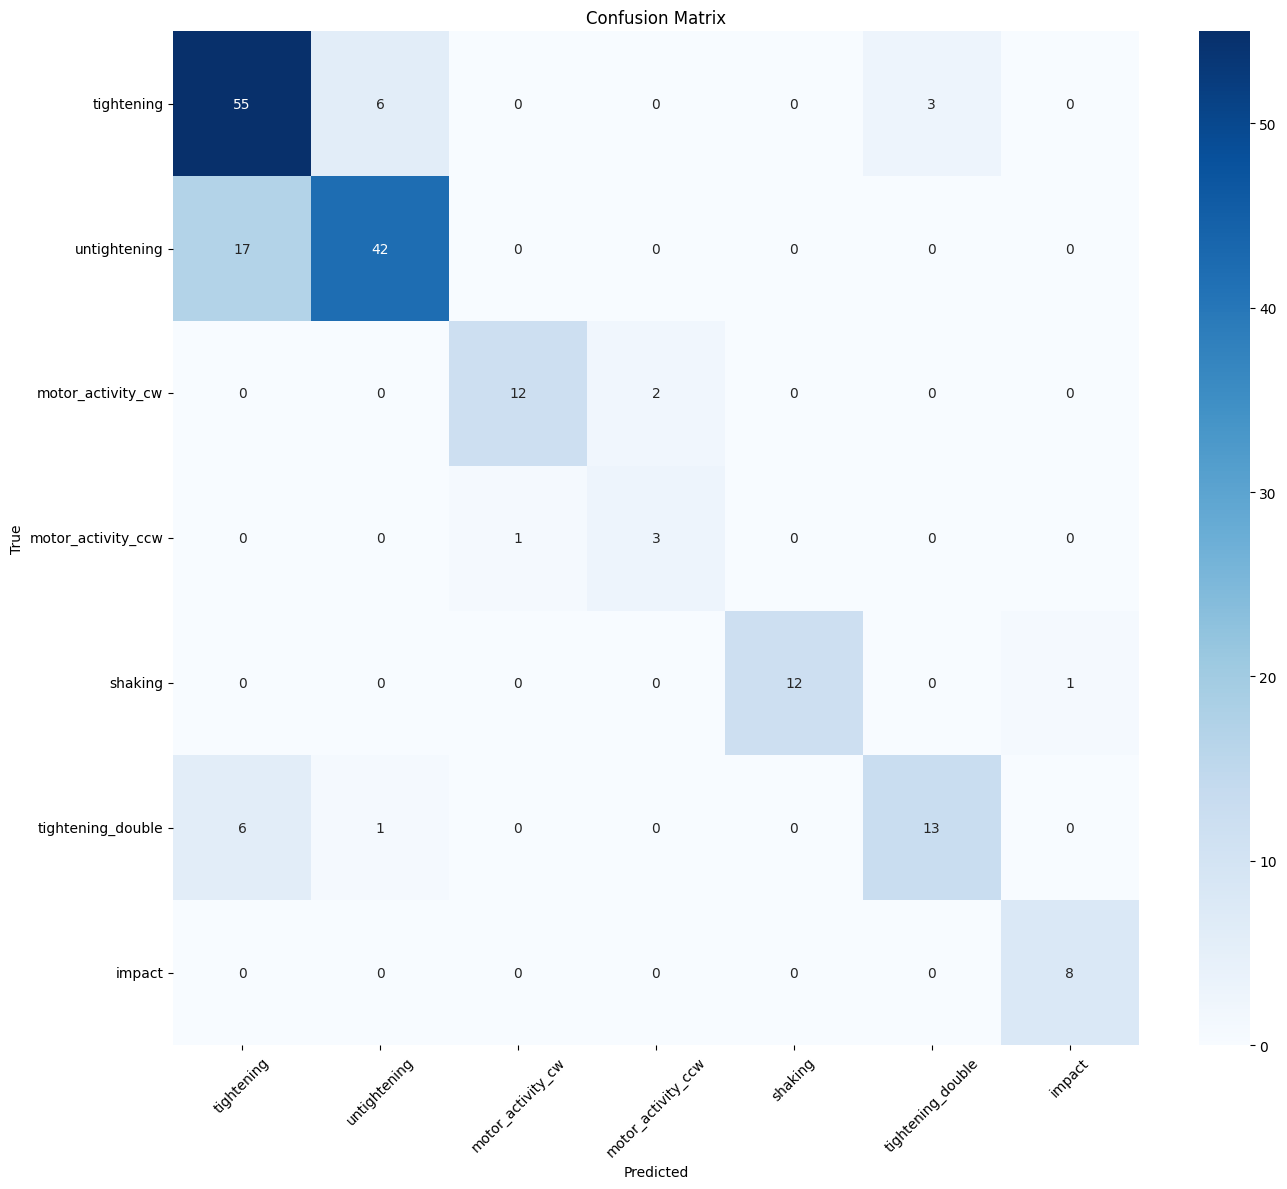


Classification Report:
                    precision    recall  f1-score   support

        tightening       0.71      0.86      0.77        64
      untightening       0.86      0.71      0.78        59
 motor_activity_cw       0.92      0.86      0.89        14
motor_activity_ccw       0.60      0.75      0.67         4
           shaking       1.00      0.92      0.96        13
 tightening_double       0.81      0.65      0.72        20
            impact       0.89      1.00      0.94         8

          accuracy                           0.80       182
         macro avg       0.83      0.82      0.82       182
      weighted avg       0.81      0.80      0.80       182



In [20]:
# ---------------- Evaluation on New Data ---------------- #
new_loader = DataLoader(TensorDataset(X_tensor_test, y_tensor_test), batch_size=batch_size, shuffle=False)


# Perform evaluation:
model.eval()
predicted_labels = []
true_labels = []


with torch.no_grad():
    for inputs, labels in new_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        predicted_labels.extend(preds.cpu().numpy()) 
        true_labels.extend(labels.numpy()) 


# Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"\nFinal Accuracy: {accuracy:.4f}")
print(f"Final Weighted F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_names = [label_info[i] for i in valid_labels]
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))
